In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

from sourcesep.models.Ca_DA_unet import LitBaseUnet
from sourcesep.models.helpers import H5Dataset
from sourcesep.utils.config import load_config

import numpy as np
from torch.utils.data import DataLoader, Subset
import torch

In [2]:
expt = "02_ca-da_test"

paths = load_config(dataset_key="all")
expt_path = paths["root"] / "results" / expt
sim_name = "2023-05-23_ca-da"
h5_filename = str(paths["root"] / "sims" / f"{sim_name}_val.h5")
dataset = H5Dataset(h5_filename=h5_filename, n_timesamples=2048)

Paths are for dataset tagged: all


In [3]:
import h5py

paths = load_config(dataset_key="all")
f = h5py.File(paths["root"] / "HSFP_636970_2022-11-14-12-34-14_data_preprocessed.hdf5", "r")

xj = {}
xj[0] = f["Channel3"][:]  # 405
xj[1] = f["Channel2"][:]  # 473
xj[2] = f["Channel1"][:]  # 560

t = f["Time"][:]
l = f["Wavelength"][:]

dat_O = np.concatenate([xj[0][:, None, :], xj[1][:, None, :], xj[2][:, None, :]], axis=1)

T = dataset.f["T_arr"][:].size
J = 3
I = 2

dat = {}
dat["A"] = np.zeros((T, 2))
dat["B"] = np.zeros((3, 60))
dat["E"] = np.zeros((3, 60))
dat["H_dox"] = np.zeros((T,))
dat["H_ox"] = np.zeros((T,))
dat["L_arr"] = l.ravel()
dat["M"] = np.zeros((T,))
dat["Mu_dox"] = np.zeros((60,))
dat["Mu_ox"] = np.zeros((60,))
dat["N"] = np.zeros((T, 3))
dat["O"] = dat_O
dat["S"] = np.zeros((2, 60))
dat["T_arr"] = f["Time"][:]
dat["W"] = np.zeros((2, 3))

Paths are for dataset tagged: all


In [4]:
import os
import h5py


def to_disk(dat, filepath=None):
    assert filepath is not None, "filepath is None"
    max_chunk_size = 1000
    if os.path.exists(filepath):
        print(f"Removing {filepath}")
        os.remove(filepath)

    with h5py.File(filepath, "a") as f:
        for key in dat.keys():
            # print(f"Creating {key}")
            chunk_size = min(max_chunk_size, dat[key].shape[0])
            f.create_dataset(
                key,
                data=dat[key],
                shape=dat[key].shape,
                maxshape=dat[key].shape,
                chunks=(chunk_size, *dat[key].shape[1:]),
                dtype="float",
            )
    print(f"Saved to {filepath}")
    return


# write experimental data to disk in format that can be used by dataloaders
to_disk(dat, paths["root"] / "HSFP_636970_2022-11-14-12-34-14_data_preprocessed_simformat.h5")

Removing /home/rohan/Local/code/sourcesep/data/HSFP_636970_2022-11-14-12-34-14_data_preprocessed_simformat.h5
Saved to /home/rohan/Local/code/sourcesep/data/HSFP_636970_2022-11-14-12-34-14_data_preprocessed_simformat.h5


In [5]:
h5_filename = paths["root"] / "HSFP_636970_2022-11-14-12-34-14_data_preprocessed_simformat.h5"
dataset = H5Dataset(h5_filename=str(h5_filename), n_timesamples=2048)

In [6]:
overlap = 1024
if overlap is not None:
    subset_idx = np.arange(0, len(dataset), step=2048 - overlap)
else:
    subset_idx = np.arange(0, len(dataset), step=2048)

dataloader = DataLoader(
    Subset(dataset, subset_idx), batch_size=subset_idx.size, shuffle=False, num_workers=8, pin_memory=True
)

In [7]:
device = torch.device("cpu")

from scipy.ndimage import uniform_filter1d

batch = next(iter(dataloader))
batch["O"] = uniform_filter1d(batch["O"], size=15, axis=1)[:, np.arange(900, step=5), :]
batch["O"] = torch.as_tensor(batch["O"], dtype=torch.float32, device=device)

In [8]:
model_name = "best-val-exp-var_epoch=646"
model = LitBaseUnet.load_from_checkpoint(expt_path / f"{model_name}.ckpt")
model = model.to(device)
model = model.eval()

In [9]:
pred_A_torch = model.A_transform_inv(model.model(batch["O"].to(device)))
pred_A = pred_A_torch.detach().cpu().numpy()

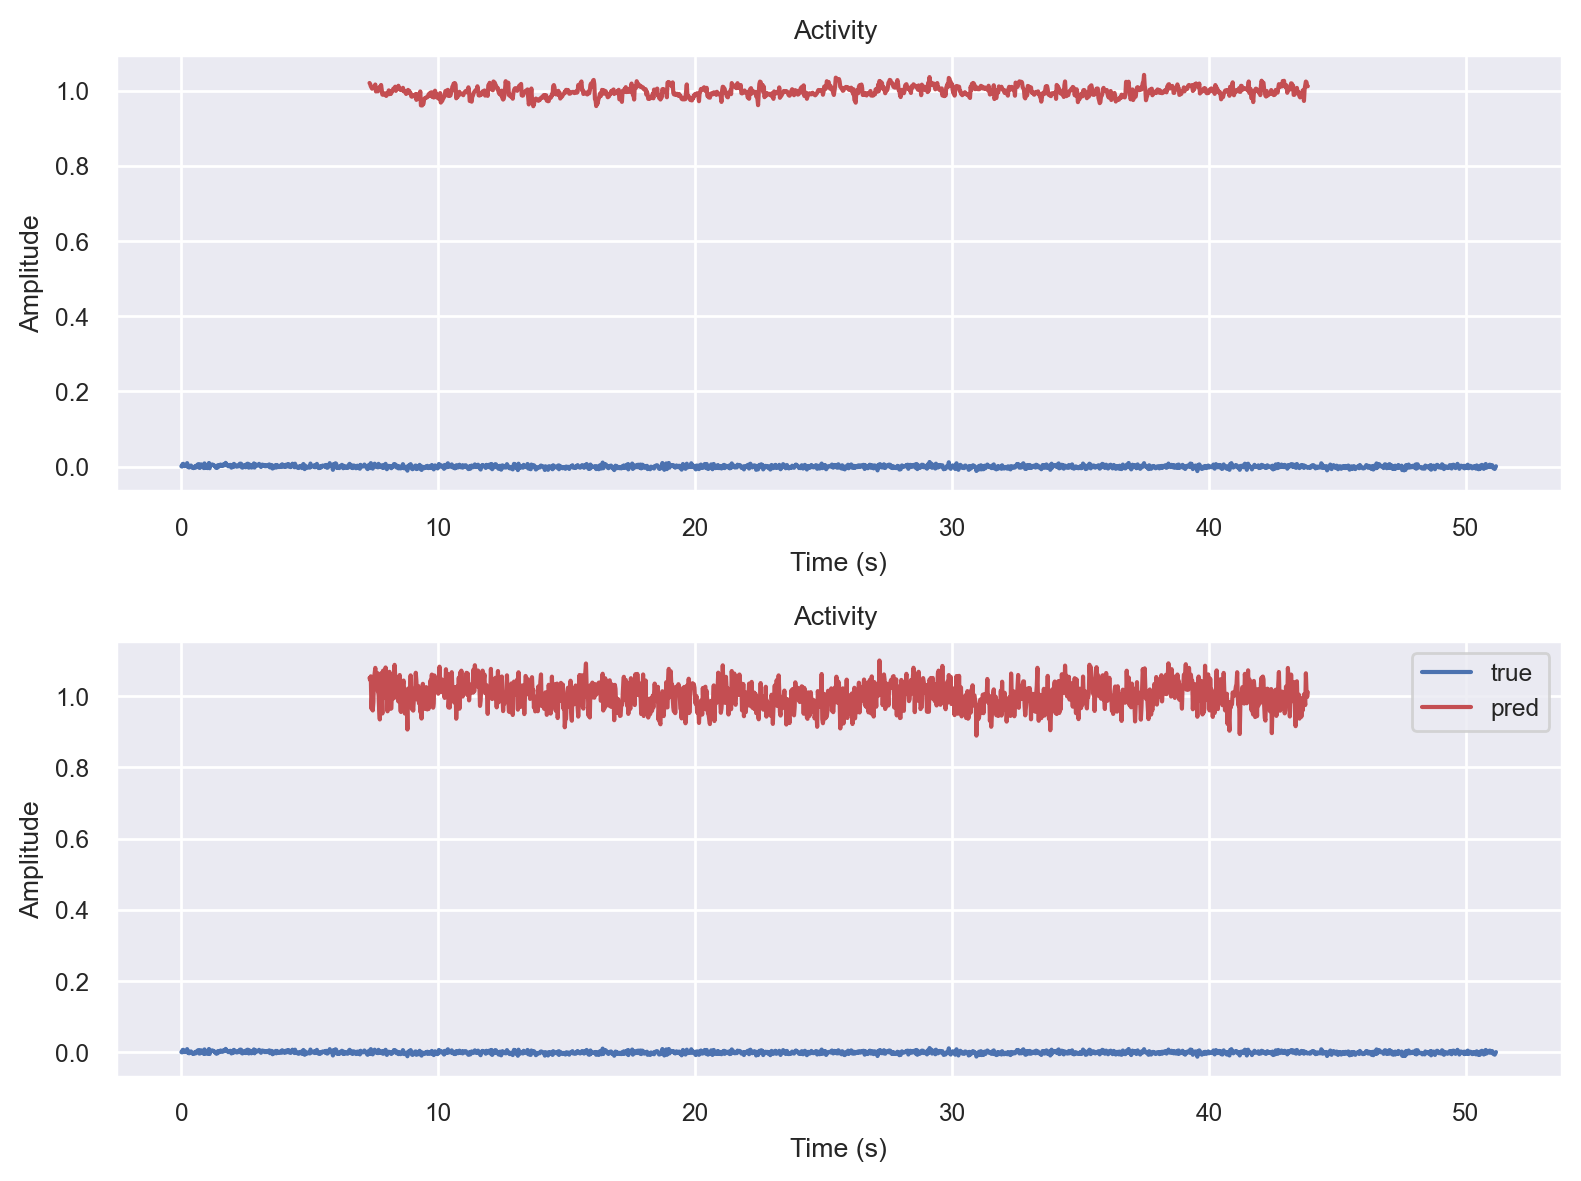

In [10]:
T_arr = np.arange(2048) / 40.0
offset = 0.0
batch_idx = 5
l = np.arange(400, 700, 5)


def df_over_f(x):
    return (x - x.mean(axis=0)) / x.mean(axis=0)


f, ax = plt.subplots(2, 1, figsize=(8, 6))
for i in range(2):
    ax[i].plot(
        np.squeeze(T_arr), df_over_f(np.squeeze(batch["O"][batch_idx, np.where(l == 610)[0], :])), c="b", label="true"
    )
    ax[i].plot(T_arr[model.pad : -model.pad], pred_A[batch_idx, i, :], c="r", label="pred")
    ax[i].set(xlabel="Time (s)", ylabel="Amplitude", title="Activity ")
plt.legend()
plt.tight_layout()
plt.show()